In [0]:
%matplotlib inline

In [0]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import cv2
import os
from google.colab import drive

In [0]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA, KernelPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [0]:
drive.mount('/content/drive')
datasetpath = '/content/drive/My Drive/Machine Learning/face_dataset_1/'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def read_faces(path,num_person,num_face):
    resize = False
    img = cv2.imread(path+'1/1.jpg')
    img = img[:,:,1]
    [height,width] = img.shape
    if height > 200:
        img = cv2.resize(img,(150, 200))
        resize = True
    [height,width] = img.shape
    imgsize = height * width
    imgnum = num_person * num_face
    faces = np.zeros((imgnum,imgsize),dtype=np.uint8)
        
    for i in range(num_person):
        for j in range(num_face):
            img = cv2.imread(path+str(i+1)+'/'+str(j+1)+'.jpg')  
            if resize:
                img=cv2.resize(img,(height,width))
            gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces[i*num_face+j,:]=gimg.ravel()
            
    return faces


In [0]:
num_person = len(os.listdir(datasetpath)) - 1
num_face = len(os.listdir(datasetpath+'s1/'))
print("There are",num_person,"subjects in this dataset, each has",num_face,"photos")
#faces = read_faces(datasetpath+'s',num_person,num_face)
faces = np.load(datasetpath+'facedata1.npy')

There are 200 subjects in this dataset, each has 14 photos


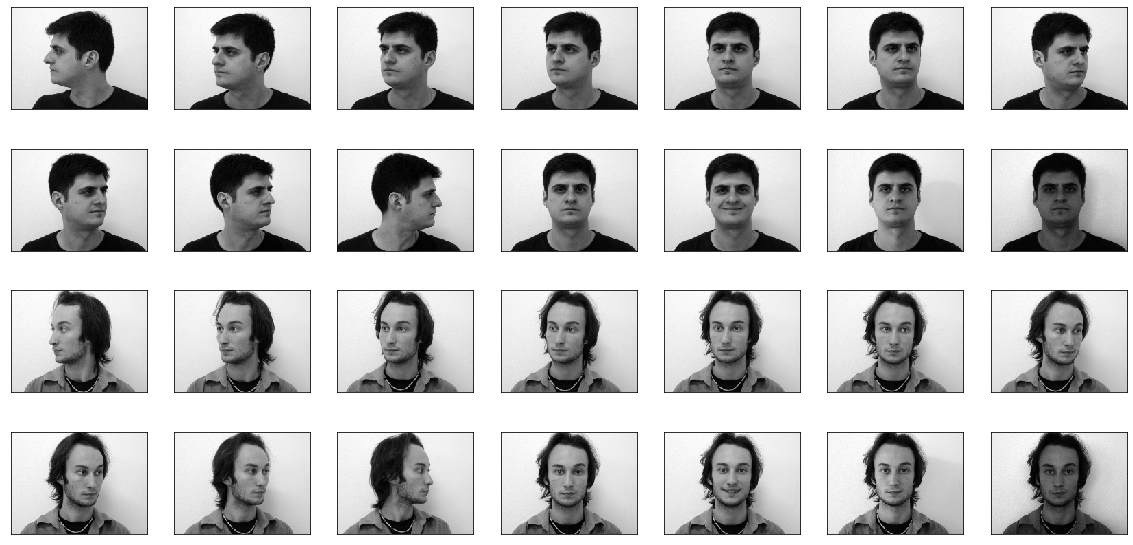

In [0]:
fig = plt.figure(figsize=(20, 10))
# plot several images
for i in range(28):
    ax = fig.add_subplot(4, 7, i + 1, xticks=[], yticks=[])
    ax.imshow(faces[i].reshape(150,200),cmap=plt.cm.gray)

In [0]:
y = np.arange(1,num_person+1)
facelabel = np.repeat(y, num_face, axis=0)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(faces,facelabel, random_state=0)

print(X_train.shape, X_test.shape)

(2100, 30000) (700, 30000)


In [0]:
pca = PCA(n_components=100, whiten=True)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

In [0]:
print(pca.explained_variance_ratio_[0:20])

[0.30280139 0.14578814 0.08297214 0.05139823 0.04516899 0.02578428
 0.02240323 0.01635359 0.01526885 0.0133871  0.01260881 0.01074669
 0.0091259  0.00801633 0.00779934 0.00662655 0.00650183 0.00560996
 0.00534618 0.0050393 ]


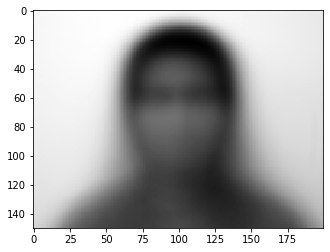

In [0]:
plt.imshow(pca.mean_.reshape(150,200),cmap=plt.cm.gray)

In [0]:
print(pca.components_.shape)

(100, 30000)


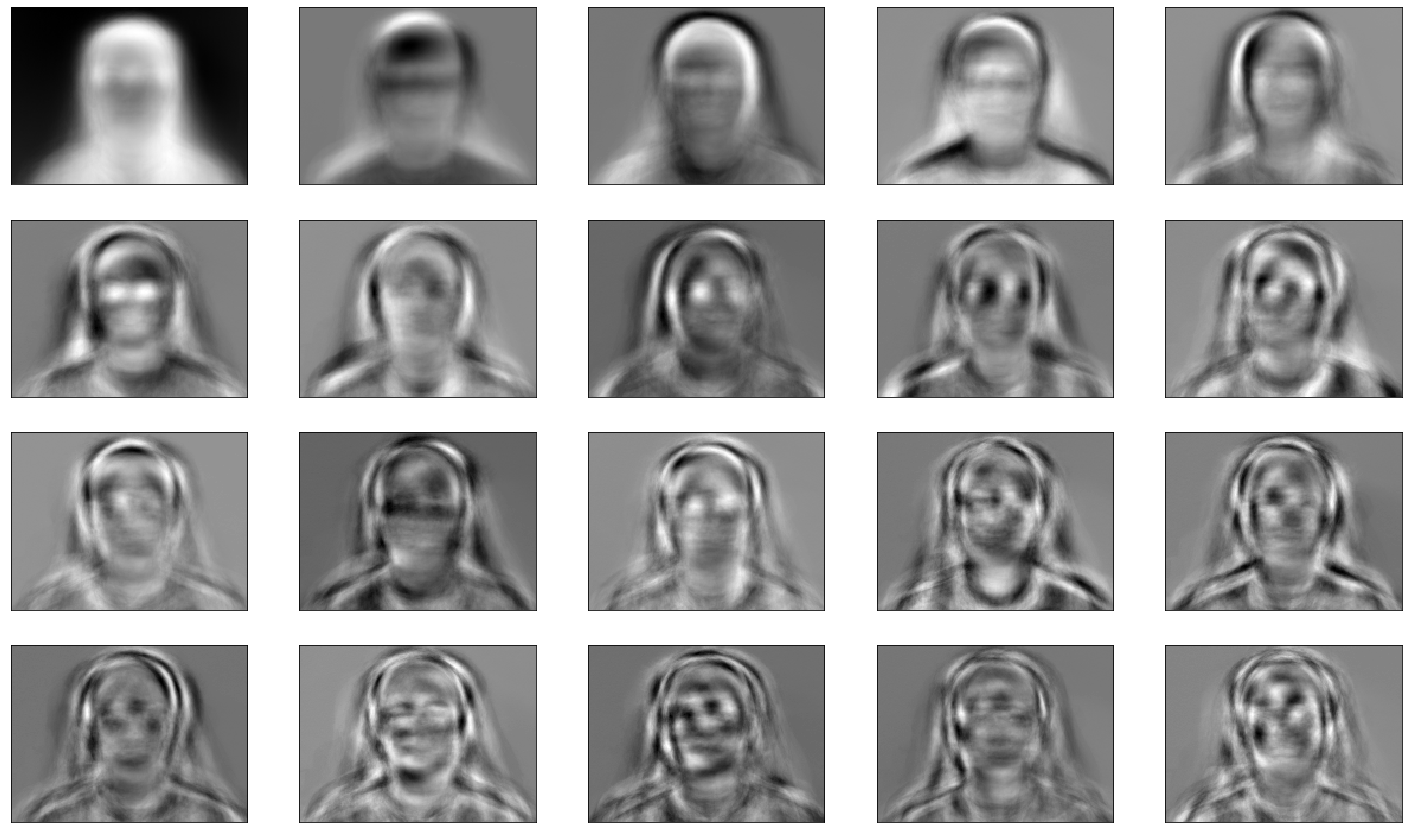

In [0]:
# visulize principal components
fig = plt.figure(figsize=(25, 15))
#for i in range(100):
#    ax = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
#    ax.imshow(pca.components_[i].reshape(150,200),cmap=plt.cm.gray)
for i in range(0,100,5):
  ax = fig.add_subplot(4,5,i/5+1,xticks=[],yticks=[])
  ax.imshow(pca.components_[i].reshape(150,200),cmap=plt.cm.gray)

The components ("eigenfaces") are ordered by their importance from
top-left to bottom-right. We see that the first few components seem to
primarily take care of lighting conditions; the remaining components
pull out certain identifying features: the nose, eyes, eyebrows, etc.

With this projection computed, we can now project our original training
and test data onto the PCA basis:



In [0]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
y_train_pca = pca.transform(y_train.reshape(-1, 1))
y_test_pca = pca.transform(y_test.reshape(-1, 1))
print(X_train_pca.shape)

(2100, 100)


In [0]:
print(X_test_pca.shape)
print(y_train_pca.shape)
print(y_test_pca.shape)

(700, 100)
(2100, 100)
(700, 100)


These projected components correspond to factors in a linear combination
of component images such that the combination approaches the original
face.

Doing the Learning: MLPClassifier
-------------------------------------------

Now we'll perform MPL classification on this reduced
dataset:



In [0]:
from sklearn.neural_network import MLPClassifier
#create classifier
print("Fitting the classifier to the training set")
clf = MLPClassifier(hidden_layer_sizes=(2048,)).fit(X_train_pca, y_train)

Fitting the classifier to the training set


Finally, we can evaluate how well this classification did. First, we
might plot a few of the test-cases with the labels learned from the
training set:



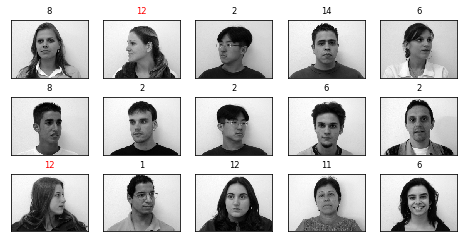

In [0]:
import numpy as np
fig = plt.figure(figsize=(8, 4))
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[i].reshape(150,200),cmap=plt.cm.gray)
    y_pred = clf.predict(X_test_pca[i, np.newaxis])[0]
    color = ('black' if y_pred == y_test[i] else 'red')
    ax.set_title(facelabel[y_pred],
                 fontsize='small', color=color)

The classifier is correct on an impressive number of images given the
simplicity of its learning model! Using a linear classifier on 150
features derived from the pixel-level data, the algorithm correctly
identifies a large number of the people in the images.

Again, we can quantify this effectiveness using one of several measures
from :mod:`sklearn.metrics`. First we can do the classification
report, which shows the precision, recall and other measures of the
"goodness" of the classification:



In [0]:
from sklearn import metrics
y_pred = clf.predict(X_test_pca)
#print(metrics.classification_report(y_test, y_pred))
print(metrics.f1_score(y_test,y_pred,average='weighted'))
print(metrics.precision_score(y_test,y_pred,average='weighted'))
print(metrics.recall_score(y_test,y_pred,average='weighted'))

              precision    recall  f1-score   support

           1       0.67      0.67      0.67         3
           2       1.00      0.60      0.75         5
           3       1.00      0.75      0.86         4
           4       0.50      1.00      0.67         1
           5       1.00      1.00      1.00         4
           6       1.00      0.50      0.67         2
           7       1.00      1.00      1.00         1
           8       1.00      0.67      0.80         3
           9       1.00      0.80      0.89         5
          10       0.75      0.75      0.75         4
          11       0.80      1.00      0.89         4
          12       1.00      1.00      1.00         2
          13       0.67      1.00      0.80         2
          14       1.00      0.40      0.57         5
          15       1.00      0.67      0.80         3
          16       0.67      1.00      0.80         2
          17       0.75      0.75      0.75         4
          18       1.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Another interesting metric is the *confusion matrix*, which indicates
how often any two items are mixed-up. The confusion matrix of a perfect
classifier would only have nonzero entries on the diagonal, with zeros
on the off-diagonal:



In [0]:
print(metrics.confusion_matrix(y_test, y_pred))

[[2 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 3 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 0 2]]


In [0]:
# Visualization
def plot_gallery(images, titles, h, w, rows=3, cols=4):
    plt.figure()
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())

def titles(y_pred, y_test, target_names):
    for i in range(y_pred.shape[0]):
        pred_name = target_names[y_pred[i]].split(' ')[-1]
        true_name = target_names[y_test[i]].split(' ')[-1]
        yield 'predicted: {0}\ntrue: {1}'.format(pred_name, true_name)

#prediction_titles = list(titles(y_pred, y_test, target_names))
#plot_gallery(X_test, prediction_titles, h, w)